Air Pollution Forecasting


In this tutorial, we are going to use the Air Quality dataset.

This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

No: row number
year: year of data in this row
month: month of data in this row
day: day of data in this row
hour: hour of data in this row
pm2.5: PM2.5 concentration
DEWP: Dew Point
TEMP: Temperature
PRES: Pressure
cbwd: Combined wind direction
Iws: Cumulated wind speed
Is: Cumulated hours of snow
Ir: Cumulated hours of rain


We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

The code below loads the “pollution.csv” file and plots each series as a separate subplot, except wind speed dir, which is categorical.

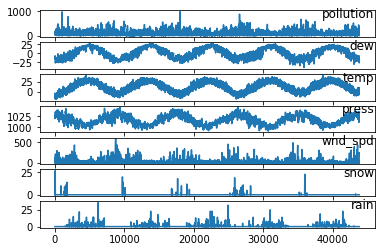

In [1]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [2]:
#import python libraries 
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
print(dataset.head())


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [10]:
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
print(np.unique(values[:,4]))
values[:,4] = encoder.fit_transform(values[:,4])
print(np.unique(values[:,4]))

['NE' 'NW' 'SE' 'cv']
[0 1 2 3]


In [11]:
# ensure all data is float
values = values.astype('float32')
print(values)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled)

[[ 129.          -16.           -4.         ...,    1.78999996    0.            0.        ]
 [ 148.          -15.           -4.         ...,    2.68000007    0.            0.        ]
 [ 159.          -11.           -5.         ...,    3.56999993    0.            0.        ]
 ..., 
 [  10.          -22.           -3.         ...,  242.69999695    0.            0.        ]
 [   8.          -22.           -4.         ...,  246.72000122    0.            0.        ]
 [  12.          -21.           -3.         ...,  249.8500061     0.            0.        ]]
[[ 0.12977867  0.35294122  0.24590163 ...,  0.00229001  0.          0.        ]
 [ 0.14889336  0.36764708  0.24590163 ...,  0.00381099  0.          0.        ]
 [ 0.15995975  0.42647061  0.22950819 ...,  0.00533197  0.          0.        ]
 ..., 
 [ 0.01006036  0.2647059   0.26229507 ...,  0.41399646  0.          0.        ]
 [ 0.00804829  0.2647059   0.24590163 ...,  0.42086649  0.          0.        ]
 [ 0.01207243  0.27941179  0.2622

In [14]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1   0.000000        0.0  0.148893  0.367647  0.245902  0.527273  0.666667   
2   0.000000        0.0  0.159960  0.426471  0.229508  0.545454  0.666667   
3   0.000000        0.0  0.182093  0.485294  0.229508  0.563637  0.666667   
4   0.037037        0.0  0.138833  0.485294  0.229508  0.563637  0.666667   
5   0.074074        0.0  0.109658  0.485294  0.213115  0.563637  0.666667   

    var6(t)   var7(t)  var8(t)  
1  0.003811  0.000000      0.0  
2  0.005332  0.000000      0.0  
3  0.008391

In [15]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [16]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((8760, 1, 8), (8760,), (35039, 1, 8), (35039,))


In [17]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [18]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
2s - loss: 0.0538 - val_loss: 0.0610
Epoch 2/50
2s - loss: 0.0353 - val_loss: 0.0587
Epoch 3/50
1s - loss: 0.0205 - val_loss: 0.0518
Epoch 4/50
1s - loss: 0.0167 - val_loss: 0.0373
Epoch 5/50
1s - loss: 0.0155 - val_loss: 0.0250
Epoch 6/50
1s - loss: 0.0151 - val_loss: 0.0222
Epoch 7/50
1s - loss: 0.0148 - val_loss: 0.0193
Epoch 8/50
1s - loss: 0.0147 - val_loss: 0.0176
Epoch 9/50
1s - loss: 0.0148 - val_loss: 0.0163
Epoch 10/50
1s - loss: 0.0146 - val_loss: 0.0151
Epoch 11/50
1s - loss: 0.0146 - val_loss: 0.0149
Epoch 12/50
1s - loss: 0.0147 - val_loss: 0.0144
Epoch 13/50
1s - loss: 0.0146 - val_loss: 0.0144
Epoch 14/50
1s - loss: 0.0146 - val_loss: 0.0144
Epoch 15/50
1s - loss: 0.0146 - val_loss: 0.0140
Epoch 16/50
1s - loss: 0.0146 - val_loss: 0.0142
Epoch 17/50
1s - loss: 0.0146 - val_loss: 0.0138
Epoch 18/50
1s - loss: 0.0143 - val_loss: 0.0139
Epoch 19/50
1s - loss: 0.0146 - val_loss: 0.0140
Epoch 20/50
1s - loss: 0.0145

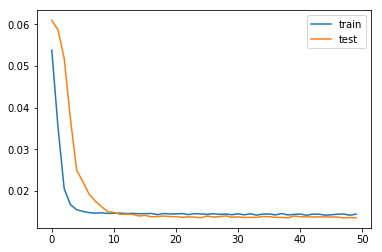

In [19]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [20]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.496


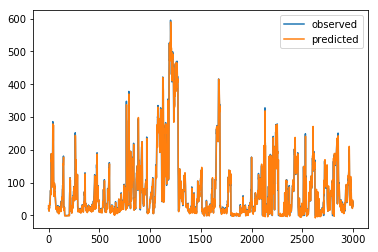

In [14]:
# plot observed and predicted values
pyplot.plot(inv_y[1:3000], label='observed')
pyplot.plot(inv_yhat[1:3000], label='predicted')
pyplot.legend()
pyplot.show()